In [1]:
import os
import torch
os.chdir("/Users/benjaminangelard/Thesis_Recommender_system")

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

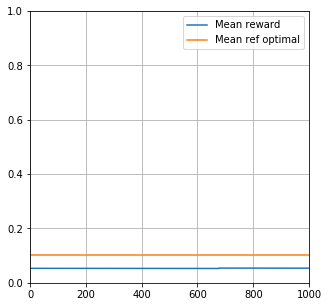

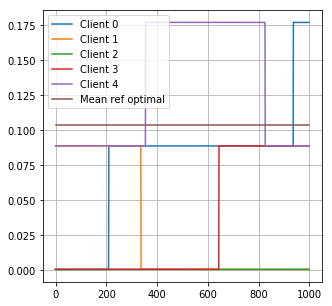

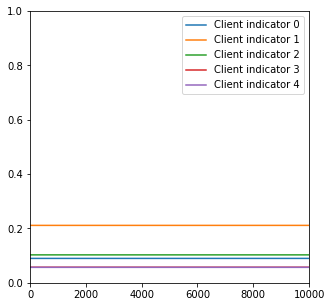

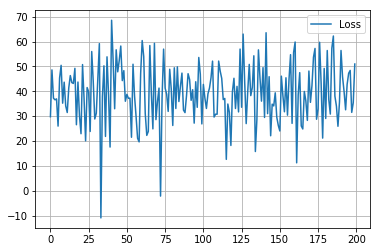

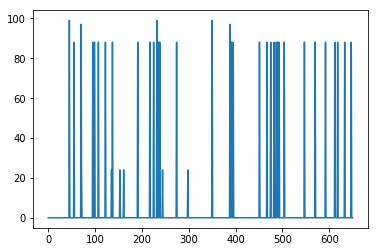

Episode 650 with reward : 0.06221992990128837 and epsilon


KeyboardInterrupt: 

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Environment.BanditEnvironment_stationary import BanditEnvironment as env_generator
from Tools import Logger
from keras.utils import to_categorical
import itertools
n_feature_item = 3
n_feature_client = 3
range_price = 100
range_color = 5
n_client = 5
n_item = 5
input_state_size = 1 + (range_color + 1 + n_item) * n_item

hidden_layer_size = 128
learning_rate = 5e-5
log_delay = 50


class ActorCritic2(nn.Module) :
    def __init__(self) :
        super(ActorCritic2, self).__init__()
        self.dense = nn.Linear(input_state_size, hidden_layer_size)
        self.probability = nn.Linear(hidden_layer_size, n_item)
        self.value = nn.Linear(hidden_layer_size, n_item)

    # CONTENT BASED x : [client_properties ; item_properties]
    # Comment gerer multi item pour l'embedding
    # Pas concatener car probleme d'ordre
    # Dot product item et client embedding
    # Commence par non content based - Seulement ID et embedding

    # Non content based : Client_ID - ListItem
    def forward(self, x) :
        client_ID = torch.tensor(x, dtype = torch.float)
        out = F.relu(self.dense(client_ID))
        probs = self.probability(out)
        value = self.value(out)
        return F.softmax(probs, dim = -1), value


class Runner() :
    def __init__(self, env, gamma = 0.99, n_episode = 10000) :
        self.model = ActorCritic2()

       # self.model.cuda()
        self.env = env
        self.optimizer = optim.RMSprop(self.model.parameters(), lr = learning_rate)
        self.memory = []
        self.gamma = gamma
        self.log_delay = log_delay
        self.n_episode = n_episode

        self.epsilon = np.finfo(np.float32).eps.item()
        self.logger = Logger.Logger(n_client, env, lim = 1000)
        self.memory_loss = []
        self.epsilon_explo = 1.0
        self.epsilon_origin = 1.0

    def select_action(self, state) :
        probs, value = self.model(state)
        m = Categorical(probs.flatten())  # [torch.argmax(value)])
        action = m.sample()
        self.memory.append((m.log_prob(action), value[action]))
        
        return action.item()

    def replay(self, rewards_log) :
        memorized = self.memory
        policy_loss = []
        value_loss = []
        rewards = []
        R = 0
        for rew in rewards_log[: :-1] :  # Compute reward for trajectoire
            R = rew + self.gamma * R
            rewards.append(R)
        rewards.reverse()
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.epsilon)  # Normalize
        for (log_prob, value), r in zip(memorized, rewards) :
            Advantage = r - value.item()  # Advantage estimate
            policy_loss.append(-log_prob * Advantage)  # Policy gradient loss
            value_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))  # Minimize R_T - prediction
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()  # Remove gradient, maintain loss value

        self.memory_loss.append(loss.data)
        loss.backward()
        self.optimizer.step()
        self.memory = []
    # Return state
    def preprocess(self, user_id, items):
        #state = [[user.get_id]]
        state = [[user_id]]
        for item in items:
            as_category = item.get_as_one_hot()
            state.append(to_categorical(as_category[0], num_classes = n_item)) # Id
            state.append([as_category[1]]) # Price
            state.append(as_category[2]) # Color
      #  print(state)
        flat = itertools.chain.from_iterable(state)
        #print(list(flat))
        return list(flat)

    def run(self) :
        print(self.model)
        rewards = []
        cumulator = []
        ep_reward = 0
        last_reward = 0
        ep_reward_cumul = []
        mean_delta = []
        mean_log = []
        delay = 100
        for i_episode in range(self.n_episode) :
            client_id, items = self.env.reset()
            ep_reward_cumul.append(ep_reward)
            mean_delta.append(np.mean(cumulator))
            mean_log.append(np.mean(ep_reward_cumul))
            if i_episode % self.log_delay == 0 :
                clear_output(True)
                self.logger.plot()
                plt.plot(self.memory_loss[-200 :], label = "Loss")
                plt.grid()
                plt.legend()
                plt.show()
                plt.plot(ep_reward_cumul)
                plt.show()

            ep_reward = 0
            for t in range(delay) :  # Collect trajectoire
                state = self.preprocess(client_id, items)
                action = self.select_action(state)
                client_id, items, reward = env.step_mono_recommendation(action)
                if reward > 0 :
                    delta = t + i_episode * delay - last_reward
                    cumulator.append(delta)
                    last_reward = t + i_episode * delay
                ep_reward += reward
                rewards.append(reward)
                self.logger.add_reward_client(reward, client_id)
            self.replay(rewards)
            rewards = []
            if i_episode % self.log_delay == 0 :
                print("Episode {} with reward : {} and epsilon".format(i_episode, ep_reward, self.epsilon))


if __name__ == '__main__' :
    env = env_generator(n_client = n_client, n_item = n_item, nb_color = range_color, range_price = range_price)
    runner = Runner(env)
    runner.run()


In [ ]:
plt.subplot(111)
axis = plt.gca()
axis.set_ylim([0, 1])

for client_index in range(5):
    plt.scatter(y = runner.logger.log_opti[client_index], x=range(len(runner.logger.log_opti[client_index])), label = "Client {}".format(client_index))
plt.legend()

In [ ]:
plt.subplot(111)
axis = plt.gca()
axis.set_ylim([0, 1])

for client_index in range(5):
    plt.plot(runner.logger.log_opti[client_index][:10], label = "Client {}".format(client_index))
plt.legend()

In [ ]:
input_state_size

In [ ]:
runner.env.get_indicator()

In [ ]:
for client in runner.env.list_client:
    print(client.center_of_price)

In [ ]:
runner.env.list_client[4]._taste

In [ ]:
for item in runner.env.list_items:
    print(item.get_properties[:2])